# Imports and constants

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from classifiers.utils.feature_extractors import ColorHistogramTransformer, HuMomentsTransformer, HaralickFeaturesTransformer

from classifiers.utils.load_balanced_data import load_balanced_data_pipeline

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold



/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load and preprocess data

In [3]:
metadata_path = "HAM10000_metadata.csv"
image_dir = "HAM10000_images_part_1"

augmented_images, augmented_labels = load_balanced_data_pipeline(metadata_path, image_dir)

Loading balanced data...
Metadata loaded.
Generating image ID list...
Image ID list generated.
Loading images for augmentation...
Augmenting images...
Images augmented.
Data loading complete.


# Train/test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

# Feature extraction and Random Forest pipeline

In [12]:
feature_union = FeatureUnion([
    ("color_histogram", ColorHistogramTransformer()),
    ("hu_moments", HuMomentsTransformer()),
    ("haralick_features", HaralickFeaturesTransformer())
])

scaler = StandardScaler()

rf_pipeline = Pipeline([
    ("features", feature_union),
    ("scaler", scaler),
    ("rf", RandomForestClassifier())
])

rf_param_grid = {
    "rf__n_estimators": [300],
    "rf__max_depth": [50],
    "rf__min_samples_split": [2],
    "rf__min_samples_leaf": [1],
    "rf__bootstrap": [True, False],
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["sqrt", "log2"]
}

rf_grid_search = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train_1d)

# Predict the labels for the test using Random Forest
y_pred_rf = rf_grid_search.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Python/3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Python/3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Python/3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Python/3.9/site-packages/sklearn/pipeline.py", line 476, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/Library/Python/3.9/site-packages/sklearn/b

# Classification report

In [13]:
# Evaluate the Random Forest classifier
print("Random Forest Classification Report:")
print(classification_report(y_test_1d, y_pred_rf))
print("Accuracy:", accuracy_score(y_test_1d, y_pred_rf))
print("Best parameters:", rf_grid_search.best_params_)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87        32
           1       0.95      0.88      0.91        40
           2       0.76      0.83      0.79        35
           3       0.88      0.69      0.77        42
           4       0.93      0.88      0.90        43
           5       0.82      0.86      0.84        42
           6       0.96      1.00      0.98        46

    accuracy                           0.87       280
   macro avg       0.87      0.87      0.87       280
weighted avg       0.88      0.87      0.87       280

Accuracy: 0.8714285714285714
Best parameters: {'rf__bootstrap': False, 'rf__criterion': 'entropy', 'rf__max_depth': 50, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}


# Confusion matrix

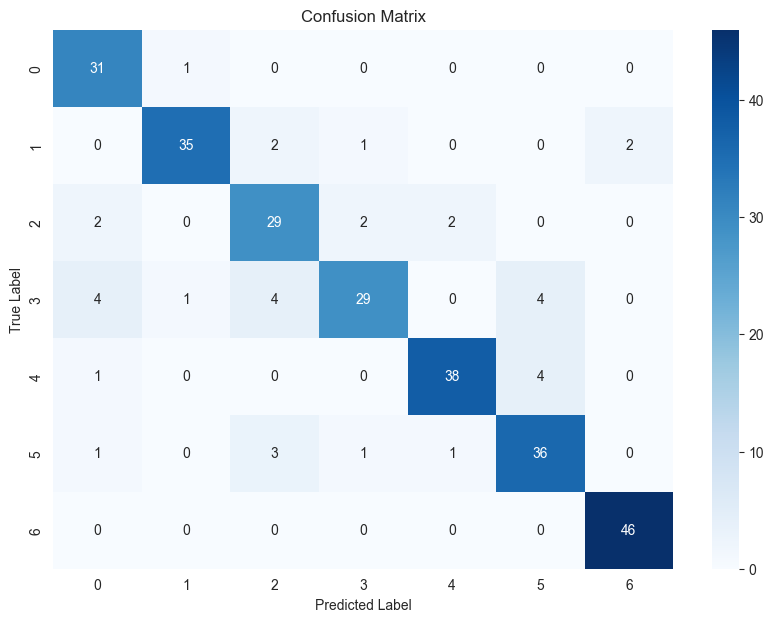

In [14]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_rf)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_1d), yticklabels=np.unique(y_test_1d))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC

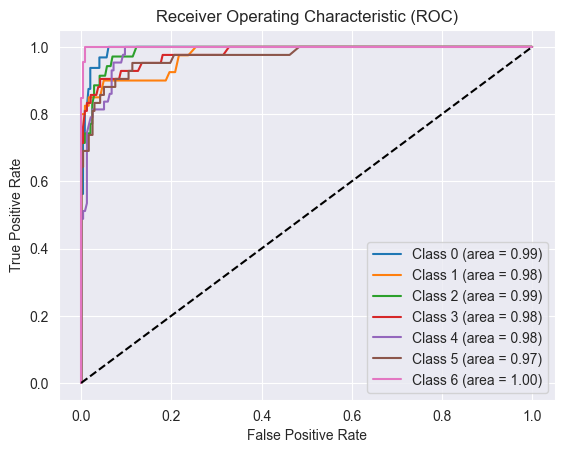

In [15]:
y_score = rf_grid_search.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_train.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_score[:, i])
    
# Plot the ROC curve for each class
plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Learning curves

In [ ]:
# Use StratifiedKFold to maintain the proportion of each class in each fold
cv = StratifiedKFold(n_splits=5)

# Calculate learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    rf_grid_search, X_train, y_train_1d, cv=cv, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, validation_scores_mean, label='Validation score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# Precision-Recall curve

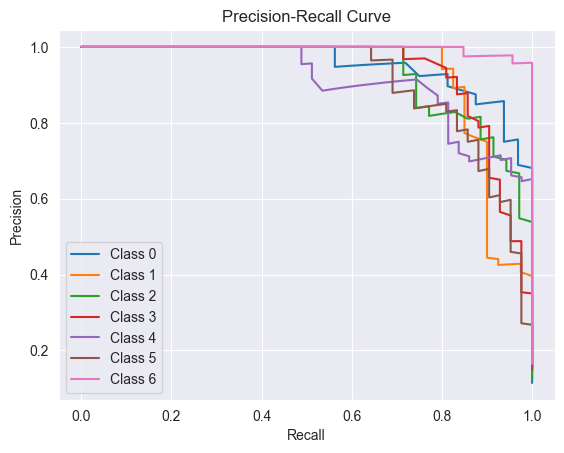

In [16]:
# Compute precision-recall curve for each class
precision = {}
recall = {}
for i in range(y_train.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])

# Plot Precision-Recall curve for each class
plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(recall[i], precision[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Save the model

In [18]:
import joblib

joblib_file = "random_forest.pkl"
joblib.dump(rf_grid_search.best_estimator_, joblib_file)

['random_forest.pkl']